In [1]:
import ll

ll.pretty()

TensorBoard/TensorBoardX not found. Disabling TensorBoardLogger. Please install TensorBoard with `pip install tensorboard` or TensorBoardX with `pip install tensorboardx` to enable TensorBoard logging.


In [2]:
from pathlib import Path

id = "asz41quw"
base_path = Path("/workspaces/repositories/jmp-peft/lltrainer")
print(base_path)

path = base_path / id / "predictions"
print(path)

pt_files = list(path.glob("*.pt"))
# print(pt_files)
# Sort by batch idx
pt_files.sort(key=lambda x: int(x.stem.rsplit("_", 1)[1][len("batch") :]))

/workspaces/repositories/jmp-peft/lltrainer
/workspaces/repositories/jmp-peft/lltrainer/asz41quw/predictions


In [3]:
import pandas as pd
from matbench_discovery import Key
from matbench_discovery.data import DATA_FILES
from pymatgen.entries.computed_entries import ComputedStructureEntry

df_summary = pd.read_csv(DATA_FILES.wbm_summary).set_index(Key.mat_id)
display(df_summary)

Loading 'wbm_summary' from cached file at '/root/.cache/matbench-discovery/1.0.0/wbm/2023-12-13-wbm-summary.csv.gz'


,formula,n_sites,volume,uncorrected_energy,e_form_per_atom_wbm,e_above_hull_wbm,bandgap_pbe,wyckoff_spglib_initial_structure,uncorrected_energy_from_cse,e_correction_per_atom_mp2020,e_correction_per_atom_mp_legacy,e_form_per_atom_uncorrected,e_form_per_atom_mp2020_corrected,e_above_hull_mp2020_corrected_ppd_mp,site_stats_fingerprint_init_final_norm_diff,wyckoff_spglib,unique_prototype
material_id,,,,,,,,,,,,,,,,,
wbm-1-1,Ac6 U2,8.0,317.48,-42.954,0.550,0.550,0.0,A3B_hP8_194_h_c:Ac-U,-42.955387,0.000,0.0,0.544327,0.544327,0.544310,0.128576,A3B_hP8_194_h_c:Ac-U,True
wbm-1-2,Ac1 Th3,4.0,137.42,-25.858,0.125,0.125,0.0,AB3_tI8_139_a_bd:Ac-Th,-25.858142,0.000,0.0,0.126190,0.126190,0.126152,0.051626,AB3_tI8_139_a_bd:Ac-Th,True
wbm-1-3,Ac1 U3,4.0,100.81,-34.934,0.768,0.768,0.0,AB3_tI8_139_a_bd:Ac-U,-34.934045,0.000,0.0,0.765339,0.765339,0.765340,0.061782,AB3_tI8_139_a_bd:Ac-U,True
wbm-1-4,Ag2 Au1 Hg1,4.0,76.26,-9.114,0.030,0.063,0.0,A2BC_cF16_225_c_a_b:Ag-Au-Hg,-9.114021,0.000,0.0,0.032195,0.032195,0.062869,0.067272,A2BC_cF16_225_c_a_b:Ag-Au-Hg,True
wbm-1-5,Ag2 Ba1 La1,4.0,124.15,-13.222,-0.178,0.100,0.0,A2BC_cF16_225_c_a_b:Ag-Ba-La,-13.222006,0.000,0.0,-0.175452,-0.175452,0.092193,0.050158,A2BC_cF16_225_c_a_b:Ag-Ba-La,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wbm-5-23304,I2 Te2 Zr2,6.0,203.35,-31.883,-0.911,0.021,0.0,ABC_oP6_59_a_a_b:I-Te-Zr,-31.885257,-0.267,0.0,-0.926076,-1.193076,0.019279,0.352661,ABC_oP6_59_a_a_b:I-Te-Zr,True
wbm-5-23305,Tl2 Zr2,4.0,92.16,-21.578,0.062,0.141,0.0,AB_cP2_221_a_b:Tl-Zr,-21.579593,0.000,0.0,0.060252,0.060252,0.139899,0.029811,AB_cP2_221_a_b:Tl-Zr,False
wbm-5-23306,Pb2 Tm1 Zr1,4.0,108.43,-21.085,-0.163,0.126,0.0,A2BC_tI8_139_d_a_b:Pb-Tm-Zr,-21.081939,0.000,0.0,-0.158310,-0.158310,0.113990,0.546470,A2BC_tI8_139_d_a_b:Pb-Tm-Zr,True


In [21]:
from typing import Any

import torch


def correct_energy(model_pred: float, batch: dict[str, Any]):
    """
    To avoid confusion for anyone reading this code, we calculate the formation energy MAE
    here and report it as the MAE for the energy above the convex hull prediction. The
    former is more easily calculated but the two quantities are the same. The formation
    energy of a material is the difference in energy between a material and its
    constituent elements in their standard states. The distance to the convex hull is
    defined as the difference between a material's formation energy and the minimum
    formation energy of all possible stable materials made from the same elements. Since
    hull, the error of a formation energy prediction directly determines the error in the
    distance to the convex hull prediction.

    A further point of clarification: whenever we say convex hull distance we mean
    the signed distance that is positive for thermodynamically unstable materials above
    the hull and negative for stable materials below it.

    See https://github.com/pbenner/matbench-discovery/blob/818173c68f434b02d4139c7fb032bd703af83fe9/matbench_discovery/preds.py#L221-L234
    From Matbench discovery:

    # dataframe of all models' energy above convex hull (EACH) predictions (eV/atom)
    df_each_pred = pd.DataFrame()
    for model in models:
        df_each_pred[model] = (
            df_preds[Key.each_true] + df_preds[model] - df_preds[Key.e_form]
        )
    """

    y_formation_pred = model_pred

    # each_true => batch["y_above_hull"] => e_above_hull_mp2020_corrected_ppd_mp
    # e_form => batch["y_formation"] => e_form_per_atom_mp2020_corrected

    y_above_hull_true = batch["y_above_hull"].item()
    y_formation_true = batch["y_formation"].item()

    y_above_hull_pred = y_above_hull_true + y_formation_pred - y_formation_true
    return (y_formation_true, y_above_hull_true), (y_formation_pred, y_above_hull_pred)

In [22]:
from typing import cast
import rich

from matbench_discovery.energy import get_e_form_per_atom
from pymatgen.core import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry
from mace.calculators import mace_mp
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.entries.compatibility import MaterialsProject2020Compatibility

print(len(pt_files))
file = pt_files[10]


data = torch.load(file, map_location="cpu")

device = torch.device("cpu")
# mace = mace_mp("https://tinyurl.com/5yyxdm76", device="cpu")
mace = mace_mp(model="medium", dispersion=False, default_dtype="float32", device="cpu")


def run_mace(model_out: dict[str, Any]):
    structure = cast(
        Structure, Structure.from_dict(model_out["relax_out"]["final_structure"])
    )
    atoms = AseAtomsAdaptor.get_atoms(structure)
    atoms.calc = mace
    mace_energy = atoms.get_total_energy()
    print(
        mace_energy,
        get_e_form_per_atom(
            {"composition": structure.composition, "energy": mace_energy}
        ),
    )

    if False:
        cse = get_cse(model_out, structure)
        cse._energy = (
            mace_energy  # cse._energy is the uncorrected energy  # noqa: SLF001
        )
        cse._structure = structure  # noqa: SLF001

        cse_list = MaterialsProject2020Compatibility().process_entries(
            [cse], verbose=False, clean=True
        )
        assert len(cse_list) == 1
        cse = cse_list[0]
        e_form = get_e_form_per_atom(cse)
    else:
        e_form = get_e_form_per_atom(
            {"composition": structure.composition, "energy": mace_energy}
        )

    if True:
        id_ = data["batch"]["id"][0]
        e_form = e_form + df_summary.loc[id_, "e_correction_per_atom_mp2020"]
    return e_form


id_ = data["batch"]["id"][0]
energy = run_mace(data)
rich.print(
    energy,
    data["batch"],
    df_summary.loc[id_],
    ComputedStructureEntry.from_dict(df_cse.loc[id_]["computed_structure_entry"]),
)

(
    (y_formation_true, y_above_hull_true),
    (y_formation_pred, y_above_hull_pred),
) = correct_energy(energy, data["batch"])
rich.print(
    {"y_formation_pred": y_formation_pred, "y_above_hull_pred": y_above_hull_pred},
    {"y_formation_true": y_formation_true, "y_above_hull_true": y_above_hull_true},
)

1024
Using Materials Project MACE for MACECalculator with /root/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


[18:31:03] INFO     Using CPU                                                                     ]8;id=885586;file:///opt/conda/envs/jmp-peft/lib/python3.11/site-packages/mace/tools/torch_tools.py\torch_tools.py]8;;\:]8;id=533270;file:///opt/conda/envs/jmp-peft/lib/python3.11/site-packages/mace/tools/torch_tools.py#67\67]8;;\

Default dtype float32 does not match model dtype float64, converting models to float32.
-34.53276443481445 -1.346945554351807


-1.898195554351807
{
    'pos': array[8, 3] f32 n=24 x∈[0., 6.807] μ=2.988 σ=1.912,
    'id': ['wbm-3-22432'],
    'atomic_numbers': array[8] i64 x∈[9, 46] μ=15.875 σ=12.820 [27, 46, 9, 9, 9, 9, 9, 9],
    'cell': array[1, 3, 3] f32 n=9 x∈[0., 5.458] μ=2.277 σ=1.960 [[[4.481, 0., 2.366], [1.639, 4.176, 2.370], [0., 
0., 5.458]]],
    'y_formation': array[1] f32 [-1.878],
    'y_above_hull': array[1] f32 [-0.010],
    'natoms': array[1] i64 [8],
    'y': array[1] f32 [-0.018],
    'force': array[8, 3] f32 n=24 all_zeros,
    'tags': array[8] i64 x∈[2, 2] μ=2.000 σ=0. [2, 2, 2, 2, 2, 2, 2, 2],
    'fixed': array[8] bool all_zeros [False, False, False, False, False, False, False, False],
    'force_norm_mean': array[8, 3] f32 n=24 all_zeros,
    'force_norm_std': array[8, 3] f32 n=24 x∈[0.566, 0.566] μ=0.566 σ=0.,
    'y_norm_mean': array[1] f32 [0.559],
    'y_norm_std': array[1] f32 [31.590],
    'batch': array[8] i64 all_zeros [0, 0, 0, 0, 0, 0, 0, 0],
    'ptr': array[2] i64 μ=4.000 σ=4.000 [0, 8]
}
formula                                                         Co1 F6 Pd1
n_sites                                                                8.0
volume                                                              102.18
uncorrected_energy                                                 -34.369
e_form_per_atom_wbm                                                 -1.929
e_above_hull_wbm                                                    -0.056
bandgap_pbe                                                           1.04
wyckoff_spglib_initial_structure               AB6C_hR24_148_a_f_b:Co-F-Pd
uncorrected_energy_from_cse                                      -34.37235
e_correction_per_atom_mp2020                                      -0.55125
e_correction_per_atom_mp_legacy                                   -0.23425
e_form_per_atom_uncorrected                                      -1.326894
e_form_per_atom_mp2020_corrected                                 -1.878144
e_above_hull_mp2020_corrected_ppd_mp                             -0.010061
site_stats_fingerprint_init_final_norm_diff                       0.058922
wyckoff_spglib                                 AB6C_hR24_148_a_f_b:Co-F-Pd
unique_prototype                                                      True
Name: wbm-3-22432, dtype: object wbm-3-22432 ComputedStructureEntry - Co1 Pd1 F6   (CoPdF6)
Energy (Uncorrected)     = -34.3723  eV (-4.2965  eV/atom)
Correction               = 0.0000    eV (0.0000   eV/atom)
Energy (Final)           = -34.3723  eV (-4.2965  eV/atom)
Energy Adjustments:
  None
Parameters:
  run_type               = GGA+U
  potcar_spec            = [{'hash': None, 'titel': 'PAW_PBE Co 06Sep2000'}, {'hash': None, 'titel': 'PAW_PBE Pd 
05Jan2001'}, {'hash': None, 'titel': 'PAW_PBE F 08Apr2002'}]
  hubbards               = {'Co': 3.32, 'Pd': 0.0, 'F': 0.0}
  potcar_symbols         = ['PAW_PBE Co 06Sep2000', 'PAW_PBE Pd 05Jan2001', 'PAW_PBE F 08Apr2002']
  is_hubbard             = True
Data:

{'y_formation_pred': -1.898195554351807, 'y_above_hull_pred': -0.03011252809166942}
{'y_formation_true': -1.8781440258026123, 'y_above_hull_true': -0.010060999542474747}

In [23]:
from tqdm.auto import tqdm


y_formation_preds: list[float] = []
y_formation_trues: list[float] = []

y_above_hull_preds: list[float] = []
y_above_hull_trues: list[float] = []


for file in tqdm(pt_files):
    data = torch.load(file, map_location=device)
    energy = run_mace(data)

    (
        (y_formation_true, y_above_hull_true),
        (y_formation_pred, y_above_hull_pred),
    ) = correct_energy(energy, data["batch"])

    y_formation_preds.append(float(y_formation_pred))
    y_formation_trues.append(float(y_formation_true))
    y_above_hull_preds.append(float(y_above_hull_pred))
    y_above_hull_trues.append(float(y_above_hull_true))

rich.print({})

  0%|          | 0/1024 [00:00<?, ?it/s]

-41.69204330444336 -0.8397929130554198
-81.82725524902344 0.11079539591471388
-29.4504337310791 -0.59996674621582
-39.48535919189453 0.014440134684245246
-28.55520248413086 -0.08010041402180985
-41.15804672241211 -0.385537226867676
-30.479095458984375 -0.3002564941406248
-41.505645751953125 -0.5079495279947915
-96.99314880371094 -1.6879624003092448
-13.583642959594727 -0.125935739898682
-34.53276443481445 -1.346945554351807
-35.266746520996094 -1.4413209315708708
-25.12244415283203 -1.6046288305664063
-43.55093002319336 -0.35996083526611383
-23.05321502685547 -0.463078756713867
-22.674274444580078 0.4762042592366538
-24.355451583862305 -0.3950103167724606
-73.53255462646484 -2.244945462646484
-31.9759578704834 -1.131176311747233
-69.44966125488281 -2.261486125488281
-65.31378936767578 -1.453718936767578
-26.418216705322266 -0.5475291763305661
-17.820777893066406 -0.327719473266602
-6.230410099029541 -0.04555252475738536
-43.96605682373047 -0.42097613728841193
-26.722604751586914 -0.419

{}

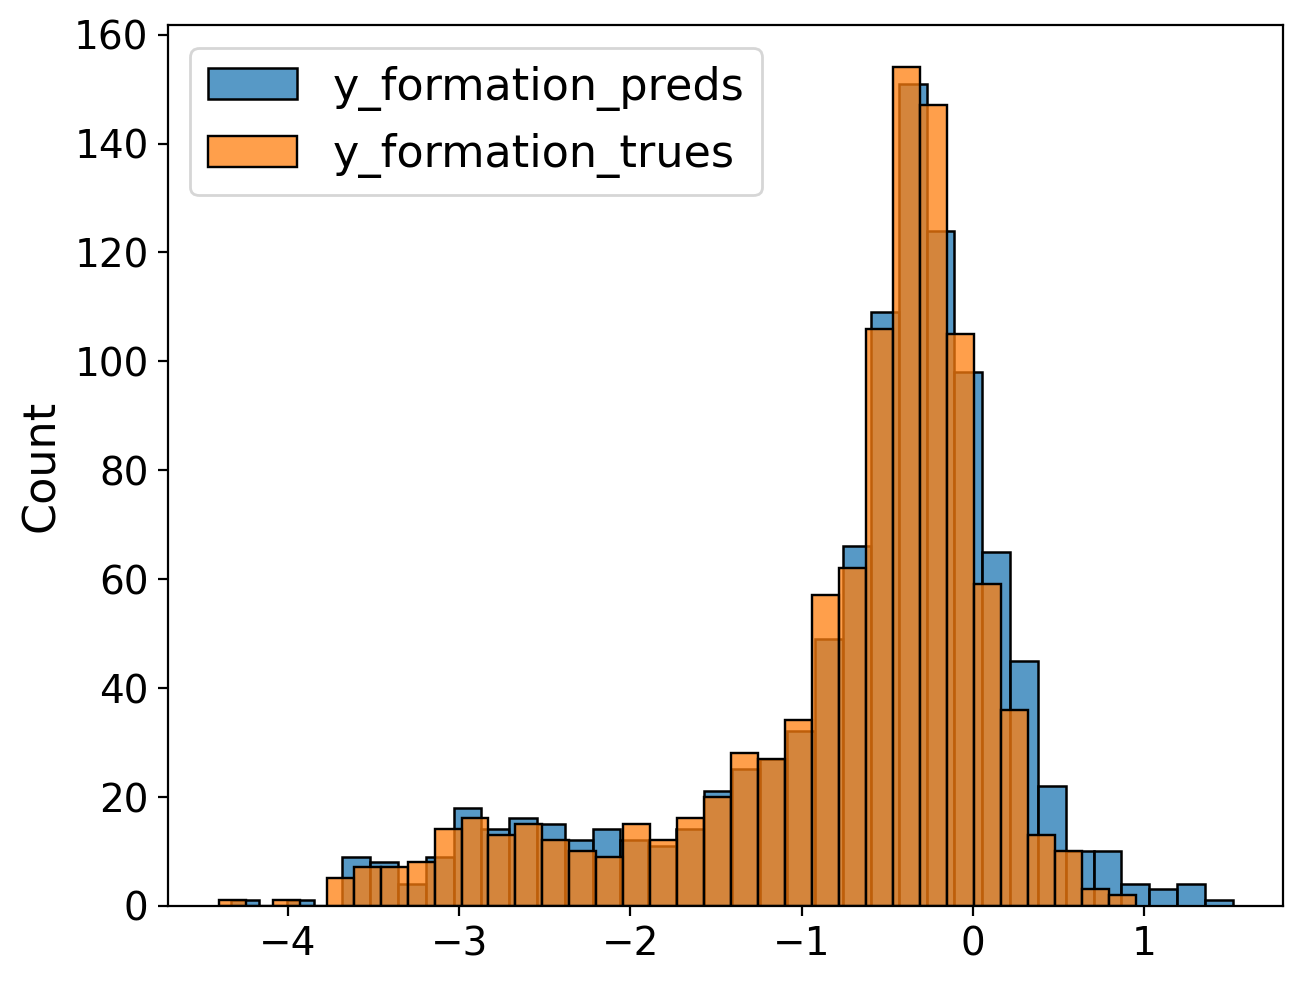

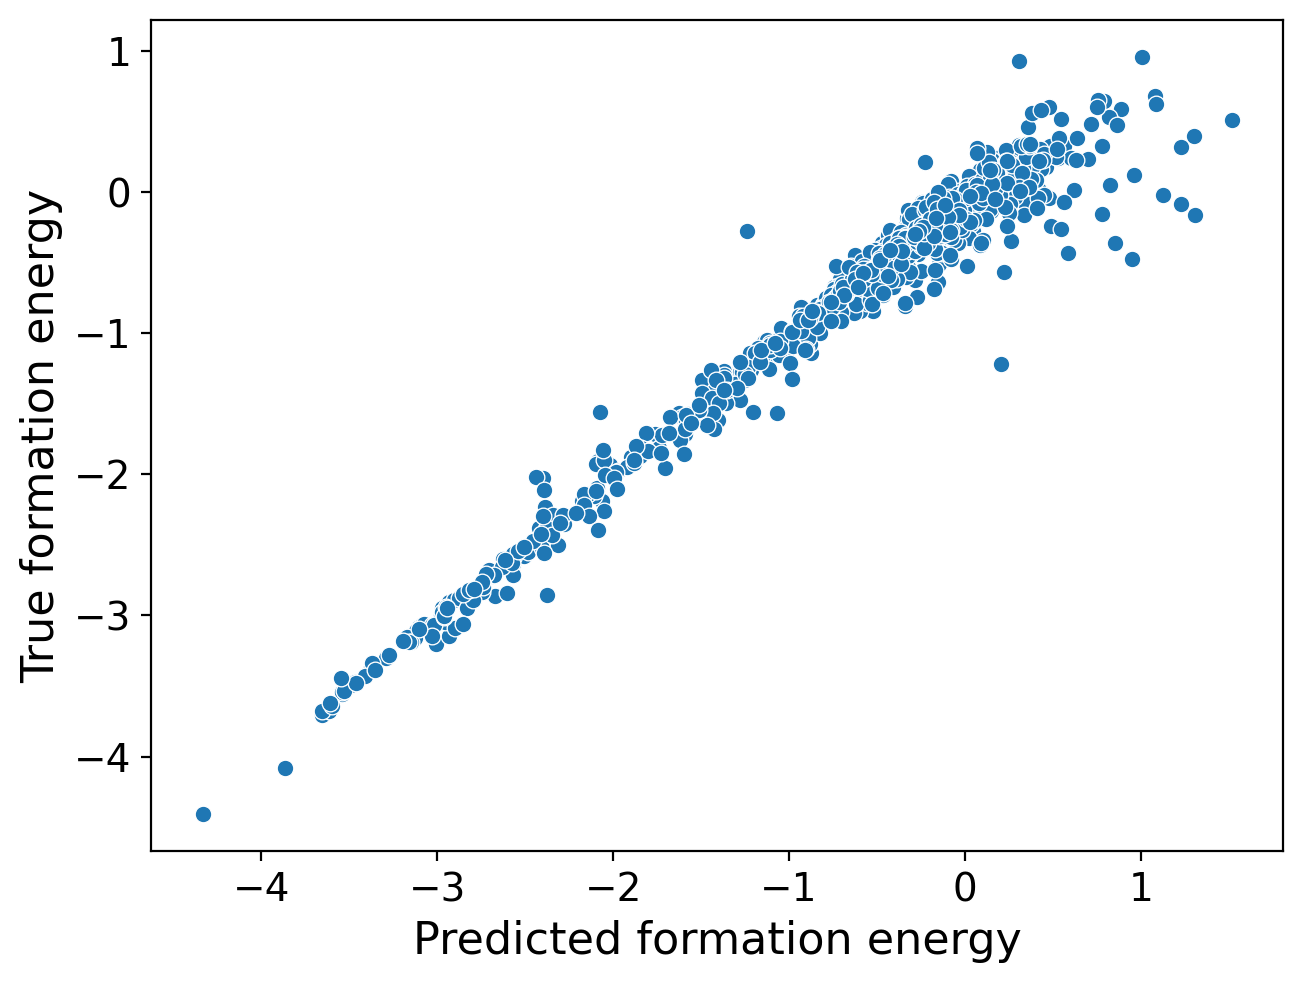

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sns.histplot(np.array(y_formation_preds), label="y_formation_preds")
sns.histplot(np.array(y_formation_trues), label="y_formation_trues")
plt.legend()
plt.show()

ax = sns.scatterplot(y=y_formation_trues, x=y_formation_preds)
ax.set_xlabel("Predicted formation energy")
ax.set_ylabel("True formation energy")


plt.show()

# sns.histplot(np.array(y_formation_preds))
# plt.show()

{
    'F1': 0.6035087719298246,
    'DAF': 4.50455242966752,
    'Precision': 0.7478260869565218,
    'Recall': 0.5058823529411764,
    'Accuracy': 0.8896484375,
    'TPR': 0.5058823529411764,
    'FPR': 0.03395784543325527,
    'TNR': 0.9660421545667447,
    'FNR': 0.49411764705882355,
    'TP': 86,
    'FP': 29,
    'TN': 825,
    'FN': 84,
    'MAE': 0.10950577124274734,
    'RMSE': 0.19752252251087338,
    'R2': 0.48677226244231353
}

{'mae': 0.10950577124274734}

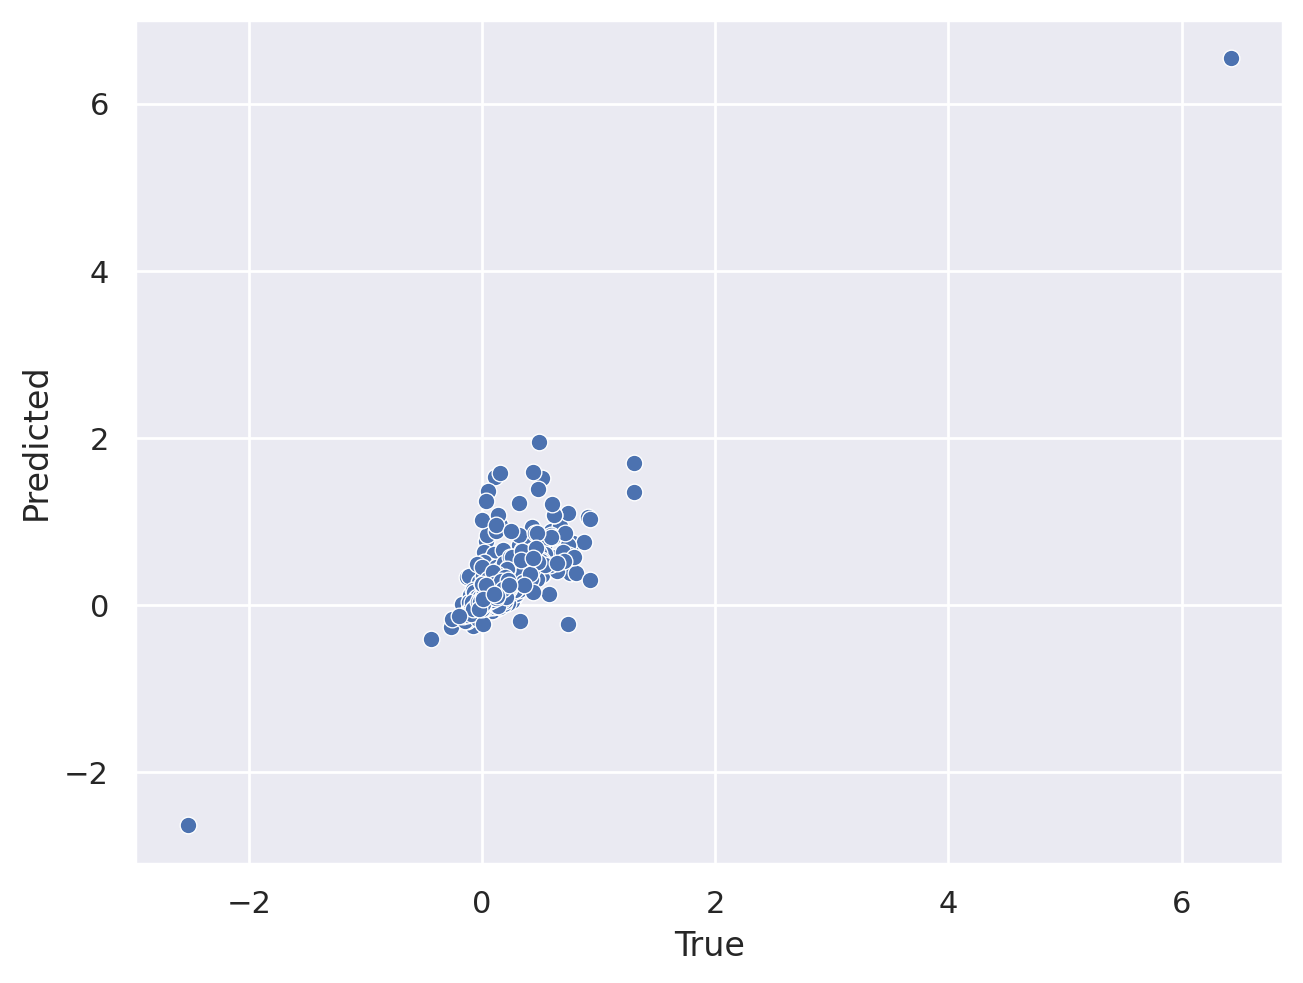

In [26]:
from matbench_discovery.metrics import stable_metrics

metrics = stable_metrics(
    np.array(y_above_hull_trues),
    np.array(y_above_hull_preds),
    fillna=False,
)
rich.print(metrics)

# Also print MAE of formation energy
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_formation_trues, y_formation_preds)
rich.print({"mae": mae})

# Draw a scatter plot of the true vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook")

plt.figure()
sns.scatterplot(x=y_above_hull_trues, y=y_above_hull_preds)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()